# Lab 3
Lucas Street, 1874989

In [11]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas
from multiprocessing import Pool

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

## Problem 1

We have about 100,000 temperature readings from an experiment. The readings are Gaussian-distributed with a mean of 12 K and a standard deviation of 0.4 K.
There are also some erroneous readings, which are added to the Gaussian-distributed data in the code below.

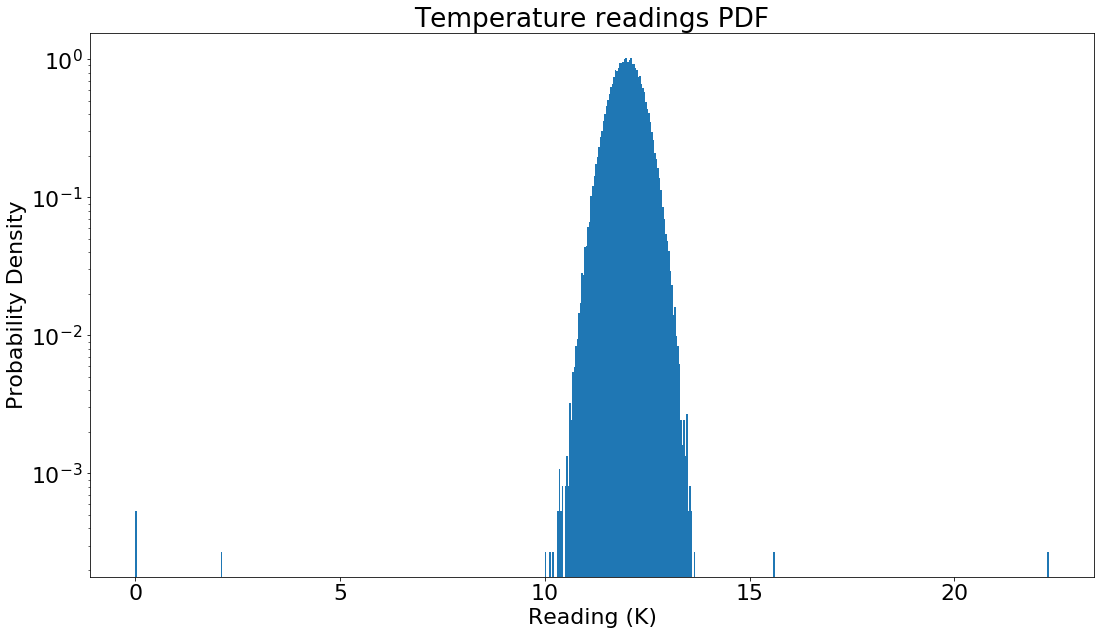

In [12]:
mean, std_dev = 12, 0.4
dist = stats.norm(mean, std_dev)
good_temp_readings = dist.rvs(100_000)
bad_temp_readings = np.array([10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
temp_readings = np.concatenate((good_temp_readings, bad_temp_readings))
plt.title('Temperature readings PDF')
plt.xlabel('Reading (K)')
plt.ylabel('Probability Density')
plt.hist(temp_readings, bins=600, density=True);
plt.yscale('log');

We want to throw out data points that aren't within some distance 12 K. The question we ask is then: At what value $X\sigma$ away from 12 K does removing readings outside this value retain the most "good" data and discard the most "bad" data?

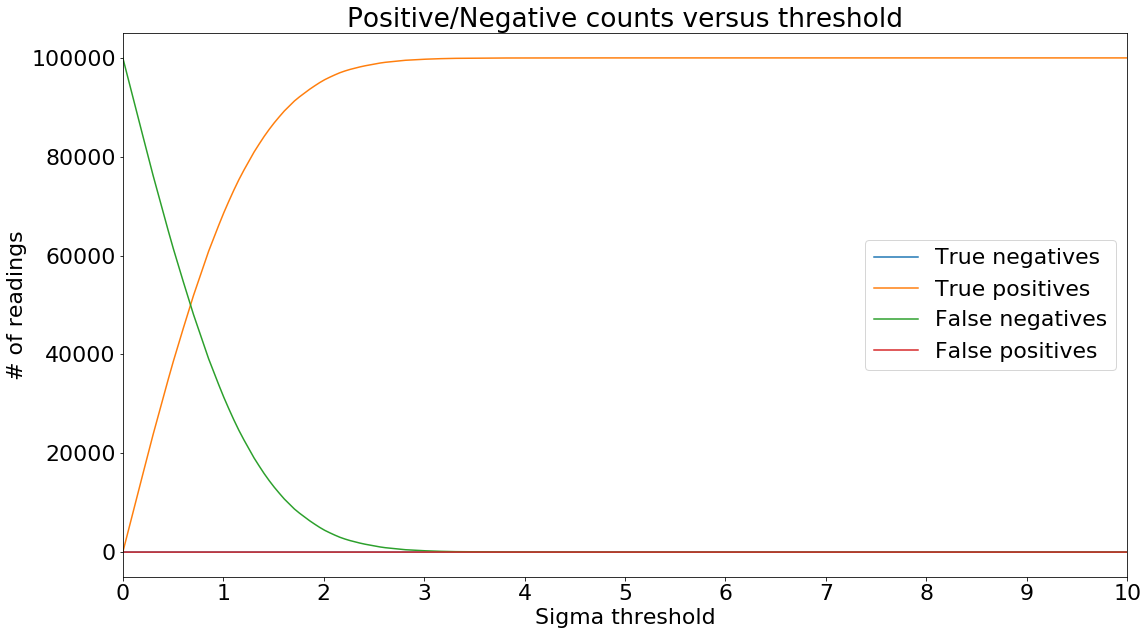

In [13]:
def get_counts(threshold):
    chosen_bad = temp_readings[(temp_readings < mean - threshold*std_dev) | (temp_readings > mean + threshold*std_dev)]
    chosen_good = temp_readings[(temp_readings > mean - threshold*std_dev) & (temp_readings < mean + threshold*std_dev)]
    true_negatives = len(np.intersect1d(chosen_bad, bad_temp_readings))
    true_positives = len(np.intersect1d(chosen_good, good_temp_readings))
    false_negatives = len(np.intersect1d(chosen_bad, good_temp_readings))
    false_positives = len(np.intersect1d(chosen_good, bad_temp_readings))
    return np.array([true_negatives, true_positives, false_negatives, false_positives])

thresholds = np.linspace(0, 10, 200)
with Pool() as p:
        results = np.transpose(np.array(p.map(get_counts, thresholds)))

def plot_counts(results, log_scale=False, draw_result_line=False):
    plt.title('Positive/Negative counts versus threshold')
    plt.xlabel('Sigma threshold')
    plt.ylabel('# of readings')
    plt.plot(thresholds, results[0]) # true negatives
    plt.plot(thresholds, results[1]) # true positives
    plt.plot(thresholds, results[2]) # false negatives
    plt.plot(thresholds, results[3]) # false positives

    if draw_result_line:
        max_true_threshold = thresholds[np.argmax(results[0] + results[1])]
        min_false_threshold = thresholds[np.argmin(results[2] + results[3])]
        print(f"Max true: {max_true_threshold} sigma, Min false: {min_false_threshold} sigma")

        plt.axvline(max_true_threshold, 0, 1, color='k', linestyle='--')
        plt.axvline(min_false_threshold, 0, 1, color='k', linestyle='--')

    if log_scale:
        plt.yscale('log')

    plt.xlim(0, 10)
    plt.xticks(range(0, 11))
    plt.legend(['True negatives', 'True positives', 'False negatives', 'False positives', 'Location of max true values', 'Location of min false values'])

plot_counts(results, log_scale=False, draw_result_line=False)

The relationship between true positives ('good' data that we keep) and false negatives ('good' data that we throw out) seems to be the same relationship between the error function `erf(a*x)` and the function `1 - erf(a*x)`, multiplied by approximately 100,000, plotted below. Let's find a more precise model by curve-fitting and plot the result.

a: 0.7082543187443964, b: 100012.58967982374


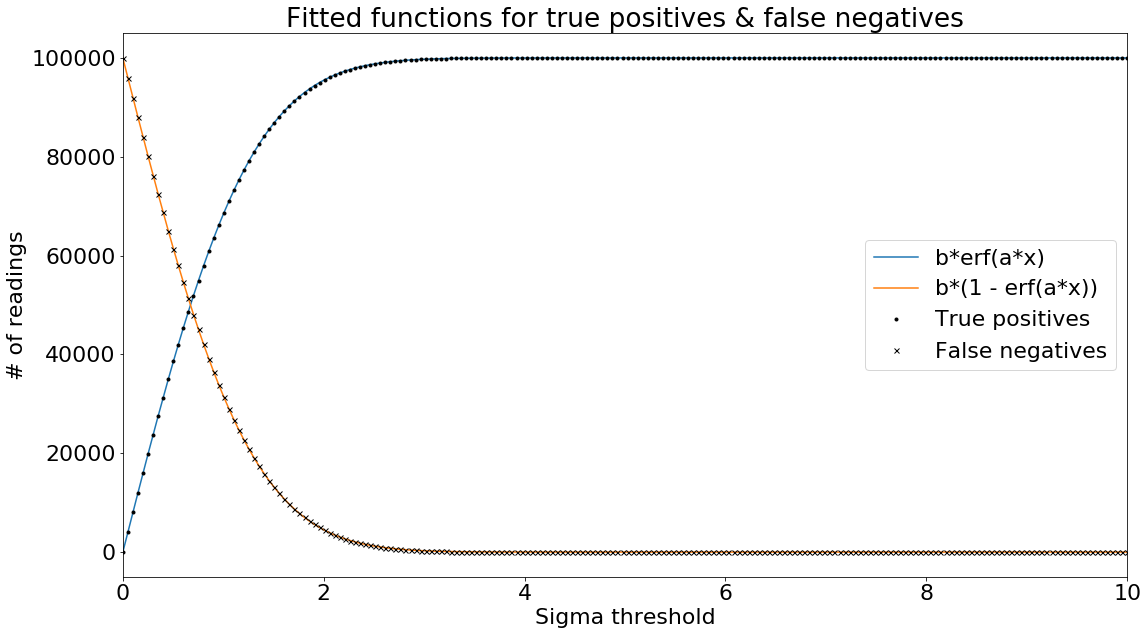

In [14]:
from scipy.special import erf

def obj(x, a, b):
    return b*(1 - erf(a*x))

# Find optimal values for a and b
(a, b), _ = curve_fit(obj, thresholds, results[2], [0.7, 1e5])
print(f"a: {a}, b: {b}")

plt.title('Fitted functions for true positives & false negatives')
plt.xlabel('Sigma threshold')
plt.ylabel('# of readings')
plt.plot(thresholds, b*erf(a*thresholds))
plt.plot(thresholds, b*(1 - erf(a*thresholds)))
plt.plot(thresholds, results[1], 'ko', markersize=3)
plt.plot(thresholds, results[2], 'kx', markersize=5)
plt.xlim(0, 10)
plt.legend([f'b*erf(a*x)', 'b*(1 - erf(a*x))', 'True positives', 'False negatives']);

This makes sense, considering that the number of occurences of some value in our background is proportional to the probability of seeing those values, and the error function is closely related to the CDF of a Gaussian distribution: $cdf(x) = \frac{1}{2} \left( 1 + erf\left( \frac{x-\mu}{\sigma\sqrt{2}} \right) \right) $. In this case, the number of true positives or false negatives is predicted fairly well by the equations $TruPos(x) = b*erf(ax)$ and $FalseNeg(x) = b*(1 - erf(ax))$, where the values of $a$ and $b$ are printed above the plot.

Now, to answer the question we asked earlier: what is the _optimal_ value of a threshold that maximizes the amount of 'good' data and minimizes the amount of 'bad' data included in our result?

Max true: 4.673366834170855 sigma, Min false: 4.673366834170855 sigma


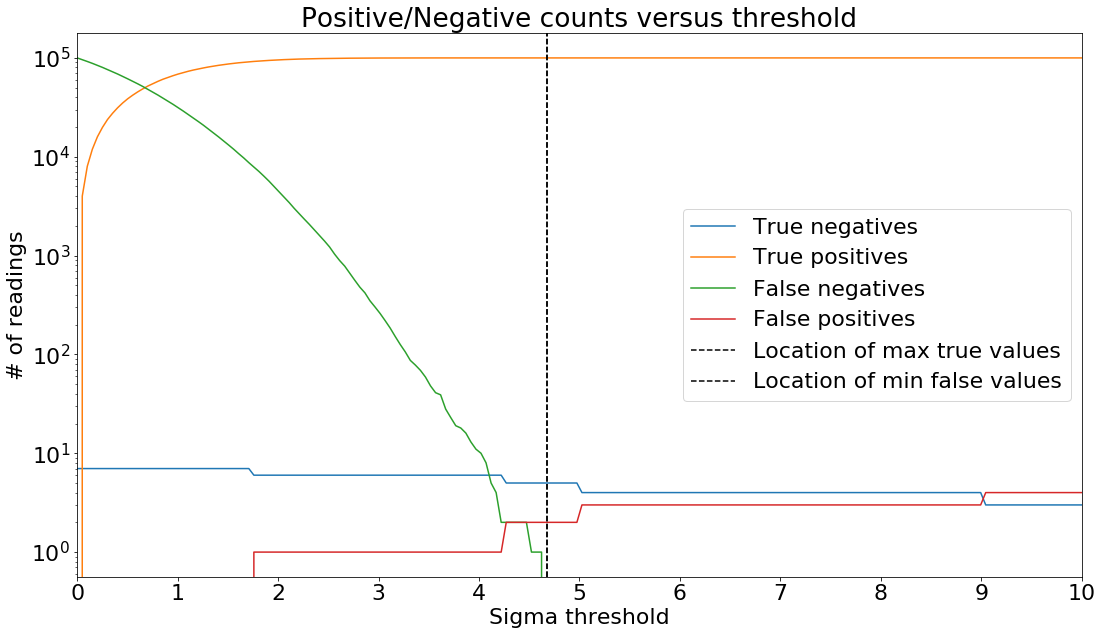

In [15]:
plot_counts(results, log_scale=True, draw_result_line=True);

The location of the dashed line indicates the position at which four quantities are optimized: the amount of good data identified as being good and the amount of bad data identified as being bad are both maximized, and the amount of bad data identified as good and the amount of good data identified as bad are both minimized.

Note that there is some false positives, or bad data, getting into our final result (the red curve above). This is unavoidable when finding the optimal location, because further decreasing the amount of false positives getting in would greatly increase the amount of false negatives, or good data identified as bad data, thrown out of our result (green curve above), which would not be optimal.

## Problem 2

Next, we want to use a telescope to find asteroids. Assume the angular positions of stationary stars in the night sky is distributed along a two-dimensional Gaussian distribution with a standard deviation of 1 arc-second. The plot below is a two-dimensional PDF where each color represents the probability density of finding the star at a particular coordinate. We let the mean value of the angular position be (0, 0).

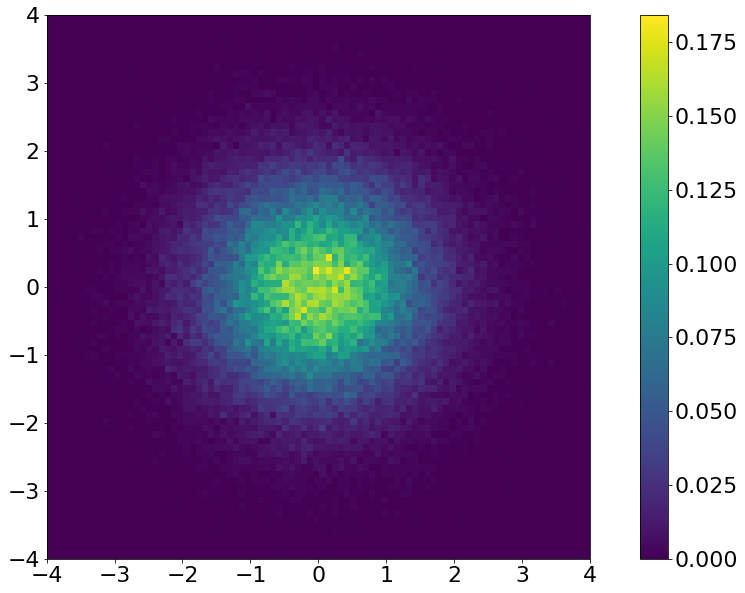

In [16]:
dist = stats.norm(scale=1)
a = dist.rvs((2, 100_000))

plt.hist2d(a[0, :], a[1, :], bins=100, density=True)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xticks(range(-4, 5))
plt.yticks(range(-4, 5))
plt.gca().set_aspect('equal', 'box')

We need to know how far an object needs to move before we can consider it an asteroid with $5\sigma$ confidence. To find this threshold, we ask: What is the distance away from the origin at which the 2-dimensional Gaussian background produces a position measurement that has a significance of $5\sigma$?

Finding the position corresponding to some probability value sounds like a job for the percent-point function `ppf`. But which distribution do we call `ppf` on? We need to find a mathematical representation of our two-dimensional PDF. Because it is a Gaussian PDF in two dimensions, the form is $PDF(x, y) = e^{-\frac{1}{2} \left( x^2 + y^2 \right)}$. To integrate this PDF, we first convert to polar coordinates: $PDF(r) = e^{-\frac{1}{2} r^2}$, then to integrate between $r = a$ and $r = b$ in polar coordinates we multiply the PDF by $r$ like so: $\int \limits_{0}^{2\pi} \int \limits_{a}^{b} re^{-\frac{1}{2} r^2} drd\theta$. If we integrate the function for $0 < r < \infty$, we get $2\pi$, so the probability of $r$ falling within $a$ and $b$ is given by $P(a < r < b) = \int \limits_{a}^{b} re^{-\frac{1}{2} r^2} dr$, the previous integral divided by $\int \limits_{0}^{2\pi} d\theta$, which is $2\pi$.

The new PDF represented by the integrand now represents that of a Rayleigh distributed variable, so we can use the `ppf` function on a Rayleigh distribution of standard deviation 1 arc-second to find the value at which we find a measurement of $5\sigma$ significance.

In [17]:
dist_2d = stats.rayleigh(scale=1)
distance = dist_2d.ppf(dist.cdf(5))

# Confirm that the distance corresponds to a 5 sigma significance
pdf_2d = lambda r: r*np.exp(-r**2 / 2)
value, error = sp.integrate.quad(pdf_2d, distance, np.inf)
print(f"Distance for 5 sigma: {distance} arc-seconds")
print(f"Converting back to sigma: {dist.ppf(1 - value)}")

Distance for 5 sigma: 5.489079776034238 arc-seconds
Converting back to sigma: 4.999999996908459


Success - the angular distance required for a $5\sigma$ movement detection is about 5.489 arc-seconds from the origin.

## Problem 3

Now let us assume we see an average number of 1 cosmic ray per minute when observing an empty moon-sized patch on the sky. If we measure the counts for an 8-hour interval, we expect to see an average of 8 * 60 = 480 cosmic rays during those 8 hours. The observations in an 8-hour time frame is represented by a Poisson distribution with a mean of $\lambda = 480$. Now let us assume we take 15 days worth of measurements, which corresponds to 15 8-hour timeframes. Because there are 15 timeframes of data and the distribution of cosmic rays seen per minute does not vary between days, we convolve each of the 15 datasets together, which gives a Poisson distribution with a mean of 15 * 480 = 7200 cosmic rays.

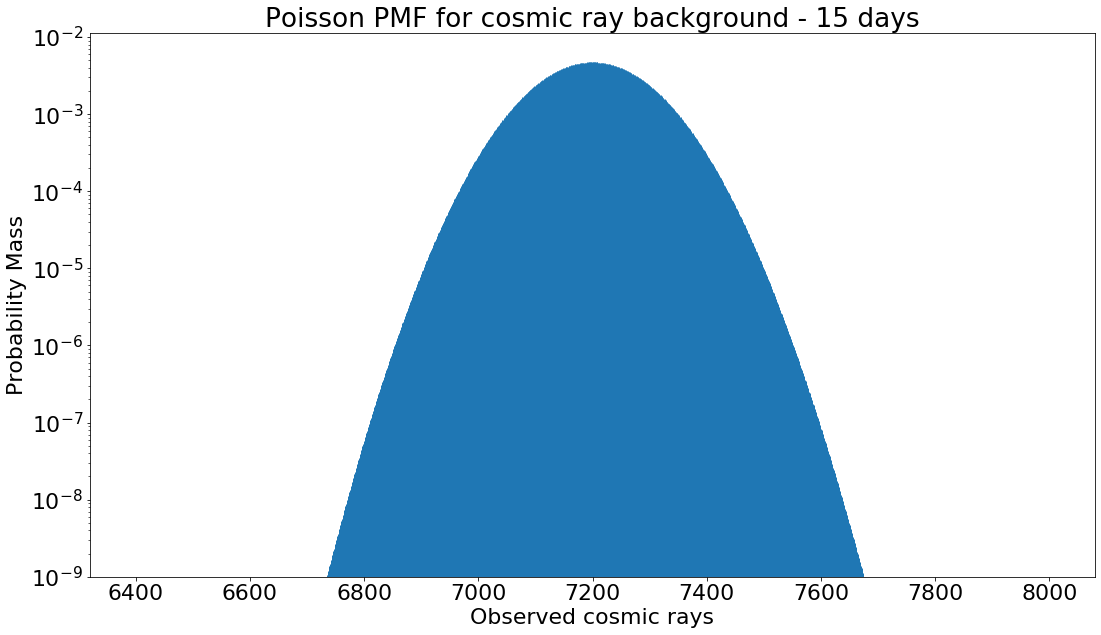

In [22]:
dist = stats.poisson(7200)
x = np.arange(6400, 8000)
pmf = dist.pmf(x)

plt.title("Poisson PMF for cosmic ray background - 15 days")
plt.xlabel("Observed cosmic rays")
plt.ylabel("Probability Mass")
plt.vlines(x, 0, pmf, linewidth=1, color="C0")
plt.yscale('log')
plt.ylim(1e-9, None);

Now let's assume we measure the number of cosmic rays seen while pointing our telescope at the moon as it moves across the sky, and we see 6800 cosmic rays over a 15-day period, measuring for 8 hours each day. What is the significance of this measurement? That is, what is the probability that the background data plotted above produced 6800 _or less_ cosmic rays in 15 days?

To answer this question, we integrate the PMF of our background from 0 to 6800, and then convert it to a sigma value. The precise formula for the integration is $P(k | \lambda) = e^{-\lambda} \sum \limits_{i=0}^{k} \frac{\lambda^i}{i!}$, where $\lambda = 7200$ and $k = 6800$.

In [19]:
prob = dist.cdf(6800)
print(prob)

1.0133280183917768e-06


In [21]:
stats.norm.ppf(prob)

-4.750747965777188

So the significance of seeing 6800 cosmic rays from observing the moon for 15 days is $4.75\sigma$.